# General Outline:

1) Link prediction
2) Recommendation systems

# 0 - Imports

In [1]:
import pandas as pd
import numpy as np
from random import choice
from datetime import datetime

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Supervised Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, \
   precision_recall_curve, roc_curve, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Network
import networkx as nx

# Recommendation system algorithms
from node2vec import Node2Vec

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 0.1 - Preprocessing

In [2]:
beer_df = pd.read_csv("beer_reviews.csv")

# change the dtype to datetime
beer_df['review_time'] = pd.to_datetime(beer_df['review_time'], unit="s")

# rename some columns in a more handy way
beer_df = beer_df.rename(columns={'beer_beerid': 'beer_id', 'review_profilename':'user'})

# remove the null values
beer_df = beer_df.dropna()

Friendly Reminder:

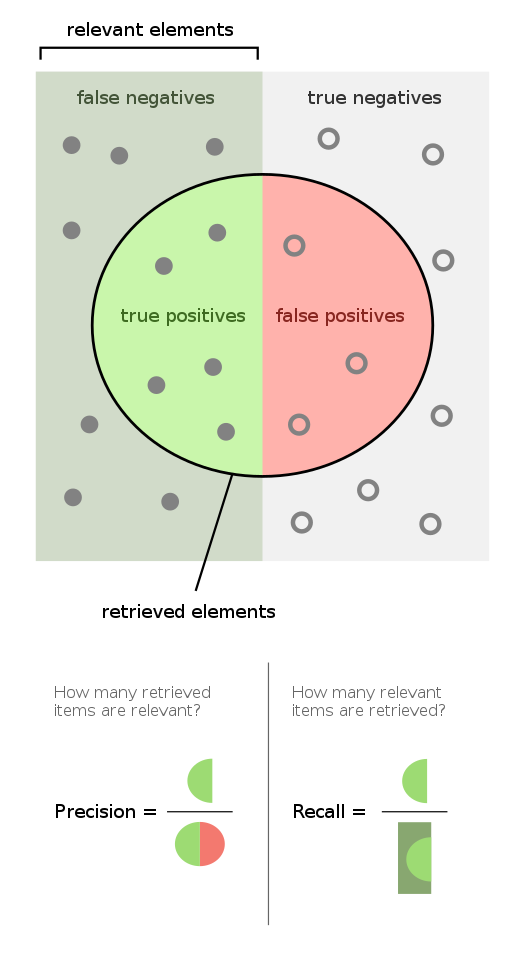

# 1 - Link Prediction

### 1.1 - Definition of the problem

Given a social network denoted as $G=(V,E)$, where a timestamp is associated with each edge $e$, the subgraph $G[t,t']$ is defined as the set of edges whose timestamps fall between $t$ and $t'$. 

Given $G[t_{0}, t'_{0}]$, the task of link prediction involves returning a set of edges not present in $G[t_{0}, t'_{0}]$ but that could be present in $G[t_{1}, t'_{1}]$, where $t'_{0}<t_{1}$

In [3]:
start_date = datetime(2006,1,1)
thres_date = datetime(2012,1,1)

mask1 = (beer_df['review_time'] >= start_date) & (beer_df['review_time'] <= thres_date)
mask2 = (beer_df['review_time'] > thres_date)

training_beer_df = beer_df.loc[mask1].sort_values(by='review_time')
testing_beer_df = beer_df.loc[mask2].sort_values(by='review_time')

In [4]:
print(f'Training beer shape: {training_beer_df.shape}')
print(f'Testing beer shape: {testing_beer_df.shape}')

Training beer shape: (1285882, 13)
Testing beer shape: (9343, 13)


Create the training beer graph

In [5]:
training_beer = nx.Graph()

# Add nodes for training_beer graph
training_beer.add_nodes_from(training_beer_df['user'], bipartite='user')
training_beer.add_nodes_from(training_beer_df['beer_name'], bipartite='beer')

# Add edges representing user-beer interactions
for _, row in training_beer_df.iterrows():
    training_beer.add_edge(row['user'], row['beer_name'], time=row['review_time'], review=row['review_overall'], abv=row['beer_abv'])  

nx.bipartite.is_bipartite(training_beer)

False

Create the testing beer graph

In [6]:
testing_beer = nx.Graph()

# Add nodes for training_beer graph
testing_beer.add_nodes_from(testing_beer_df['user'], bipartite='user')
testing_beer.add_nodes_from(testing_beer_df['beer_name'], bipartite='beer')

# Add edges representing user-beer interactions
for _, row in testing_beer_df.iterrows():
    testing_beer.add_edge(row['user'], row['beer_name'], time=row['review_time'], review=['review_overall'], abv=row['beer_abv'])  

nx.bipartite.is_bipartite(testing_beer)

True

### 1.2 - Data points

In [7]:
list_edges = np.array([{u,v} for u,v in testing_beer.edges()])
list_edges

array([{'dirtyskunk', 'Dark Truth Stout'}, {'SupaCelt', 'Rye-Chuss'},
       {'Old Jubilation', 'Jesstyr'}, ...,
       {'Heavy Seas - Hang Ten (Weizen Doppelbock)', 'Ohiovania'},
       {'tylerprince', '90 Minute IPA'},
       {'cquinn17', 'Arcadia Loch Down Scotch Ale'}], dtype=object)

First, we extract pairs of nodes connected in $G1$, whose endpoints are present in $G0$. These pairs represent the data points to which we will assign a positive label (1). By construction, we are certain that in $G0$, the elements of the connected pair were not connected; otherwise, the edge would have been inserted in $G0$ and not in $G1$.

_It's not clear how the `size` parameter should be fixed. In the prof's tutorial, he didn't provide us with any explanation nor rule of thumb. For this reason, I chose a size such that the positive datapoints are roughly 50% of the total datapoints in the testing set, avoiding imbalance._

In [8]:
positive_datapoints = np.random.choice(list_edges, replace=False, size = 5000)  

# Filter out pairs (u, v) from positive_datapoints for which both u and v are nodes in the training_beer graph. 
# It ensures that only valid node pairs are retained in positive_datapoints.
positive_datapoints = [(u,v) for u,v in positive_datapoints if training_beer.has_node(u) and training_beer.has_node(v)]

len(positive_datapoints)

4629

To obtain an equal number of objects with a label of 0, we extract pairs that are not connected in $G1$ and were also not connected in $G0$. These pairs represent the negative data points to which we assign the label '0'. We identify, therefore, those pairs that do not generate any links or connections.

In [9]:
negative_datapoints = []

# Create a list of nodes from the facebook_testing graph
nodes_set = list(training_beer.nodes())
count = 0

# Loop that continues until the number of generated negative datapoints (count) matches the number of positive datapoints
while count < len(positive_datapoints):

    # Randomly selects two nodes (u and v) from the nodes_set without replacement
    u,v = np.random.choice(nodes_set, size = 2, replace=False)

    # Check if there is no edge between nodes u and v in the training_beer graph and if both nodes are present in the training graph
    if (not training_beer.has_edge(u,v) and training_beer.has_node(u) and training_beer.has_node(v)):
        negative_datapoints.append((u,v))
        count += 1

In [10]:
len(negative_datapoints)

4629

In [11]:
dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints # entire set of objects to "represent"
datapoints[:10]

[('Red Chair NWPA', 'mjryan'),
 ('Old Rasputin XII', 'FosterJM'),
 ('Stone 11.11.11 Vertical Epic Ale', 'chilidog'),
 ('UFO White', 'iBeer16'),
 ('Ronaldo', 'soze47'),
 ('SolipsismalCat', 'Summit Black Ale'),
 ('jhartley', 'Yakima Glory'),
 ('Reaper16', 'Lagunitas Sucks Holiday Ale'),
 ('Moo Thunder Stout', 'GarthDanielson'),
 ('Maximus', 'harrymel')]

### 1.3 - Calculate coefficients on the training graph

- **Jaccard**: ranges from 0 to 1 and quantifies the similarity between two sets.

Jaccard = $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$

- **RAI**: measures the "amount" of resources that are shared between nodes $i$ and $j$. Since it considers the inverse degrees of their common neighbors, nodes with higher degrees contribute less to the RAI compared to nodes with lower degrees (reflecting the idea that common resources are more significant when they are shared with less connected nodes). The RAI ranges between 0 and 1, where a higher value indicates a greater similarity or overlap of resources between nodes $i$ and $j$.

AAI $= \sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$

- **AAI**: similar to the _Resource Allocation Index_, but it uses the logarithm of the degree of common neighbors in the denominator instead of just the degree itself. This logarithmic transformation gives less weight to connections with highly connected nodes and provides a more nuanced measure of similarity between nodes. The Adamic-Adar Index ranges from 0 to positive infinity, where a higher value indicates a greater similarity or proximity between nodes $i$ and $j$.

AAI $= \sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{\log |\Gamma(w)|}$

- **PAI**: The idea behind this index is that nodes with higher degrees have a greater influence or attractiveness, and thus they are more likely to be connected to new nodes. The more connections a node has, the more likely it is to attract additional connections in the future. This is analogous to the rich-get-richer phenomenon, where nodes that are already well-connected tend to become even more connected over time as the network grows.

PAI $ =|\Gamma(u)| |\Gamma(v)|$

In [12]:
# Jaccard
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(training_beer, datapoints)]

# Resource Allocation Index (RAI)
dataset_link_prediction['rai'] = [rai for _,_, rai in nx.resource_allocation_index(training_beer, datapoints)]

# Adamic Adar Index (AAI)
dataset_link_prediction['aai'] = [aai for _, _, aai in nx.adamic_adar_index(training_beer, datapoints)]

# Preferential Attachment Index (PAI)
dataset_link_prediction['pai'] = [pai for _,_, pai in nx.preferential_attachment(training_beer, datapoints)]

# Add the label
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]

In [13]:
dataset_link_prediction.loc[55:60]

,jaccard,rai,aai,pai,label
55,0.0,0.0,0.0,200408,1
56,0.0,0.0,0.0,178075,1
57,0.0,0.0,0.0,260568,1
58,0.0,0.0,0.0,56448,1
59,0.0,0.0,0.0,2000,1
60,0.0,0.0,0.0,17577,1


### 1.4 - Supervised Learning

In [14]:
X = dataset_link_prediction.loc[:, dataset_link_prediction.columns != 'label'] 
y = dataset_link_prediction['label']

In [15]:
X.shape, y.shape

((9258, 4), (9258,))

#### 1.4.1 - Train, test splitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7406, 4), (1852, 4), (7406,), (1852,))

#### 1.4.2 - Feature Scaling

In [17]:
# Re-scale all the feature so that they range [0,1]

ct = ColumnTransformer([
    ('minmax', MinMaxScaler(), ['jaccard','rai','aai','pai'])
])

In [18]:
link_predictor = Pipeline([
    ('preprocessing',ct),
    ('classifier',LogisticRegression(penalty='none'))
])

### 1.5 - First Model: Logistic Regression

In [19]:
link_predictor = Pipeline([
    ('preprocessing',ct),
    ('classifier',LogisticRegression())
])

In [20]:
link_predictor.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['jaccard', 'rai', 'aai',
                                                   'pai'])])),
                ('classifier', LogisticRegression())])

In [21]:
predicted_labels = link_predictor.predict(X_test)

In [22]:
# accuracy score
print(f"Accuracy Score: {round(accuracy_score(y_test, predicted_labels), 2)}")

# F1
print(f"F1 Score: {round(f1_score(y_test, predicted_labels),2)}")

# recall
print(f"Recall Score: {round(recall_score(y_test, predicted_labels),2)}")

# precision
print(f"Precision Score: {round(precision_score(y_test, predicted_labels),2)}")

Accuracy Score: 0.71
F1 Score: 0.61
Recall Score: 0.43
Precision Score: 1.0


In [23]:
cm = confusion_matrix(y_test, predicted_labels)
cm

array([[915,   0],
       [530, 407]], dtype=int64)

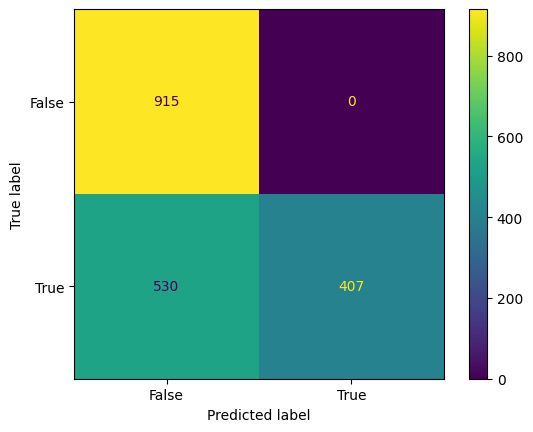

In [24]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

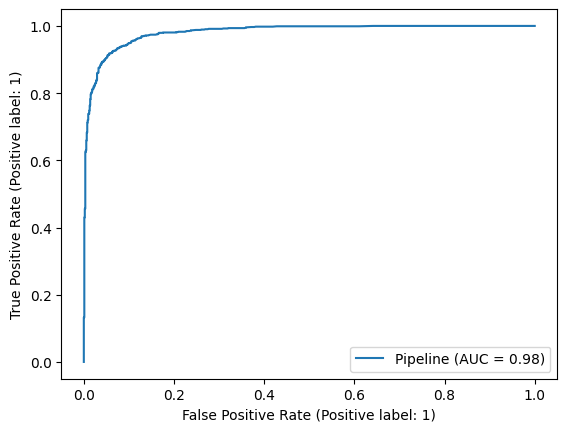

In [ ]:
roc_logistic = RocCurveDisplay.from_estimator(link_predictor, X_test, y_test)

### 1.6 - Second Model: XGBoost

In [25]:
model = GradientBoostingClassifier()

xgb_link_predictor = Pipeline([
    ('preprocessing', ct),
    ('classifier', model)
])

In [26]:
xgb_link_predictor.fit(X=X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['jaccard', 'rai', 'aai',
                                                   'pai'])])),
                ('classifier', GradientBoostingClassifier())])

In [27]:
predicted_labels_xgb = xgb_link_predictor.predict(X_test)

In [28]:
# accuracy score
print(f"Accuracy Score: {round(accuracy_score(y_test, predicted_labels_xgb), 2)}")

# F1
print(f"F1 Score: {round(f1_score(y_test, predicted_labels_xgb),2)}")

# recall
print(f"Recall Score: {round(recall_score(y_test, predicted_labels_xgb),2)}")

# precision
print(f"Precision Score: {round(precision_score(y_test, predicted_labels_xgb),2)}")

Accuracy Score: 0.92
F1 Score: 0.92
Recall Score: 0.92
Precision Score: 0.93


In [29]:
cm = confusion_matrix(y_test, predicted_labels_xgb)
cm

array([[852,  63],
       [ 77, 860]], dtype=int64)

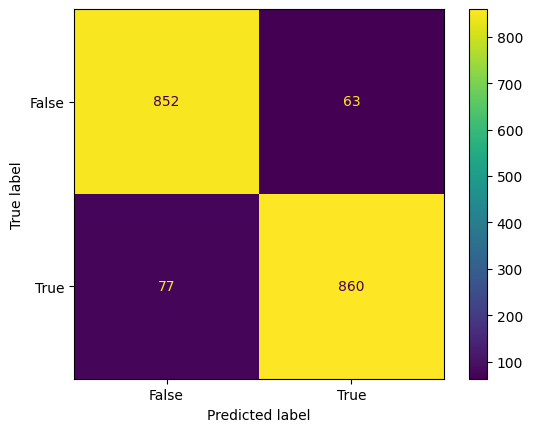

In [102]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

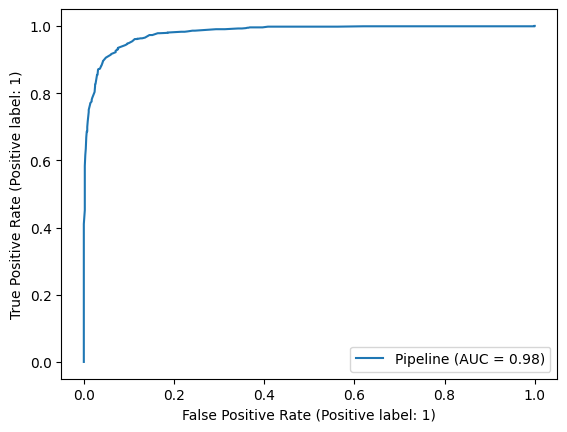

In [ ]:
roc_xgb = RocCurveDisplay.from_estimator(xgb_link_predictor, X_test, y_test)

### 1.7 - Third Model: SVC

In [103]:
model = SVC()

svc_link_predictor = Pipeline([
    ('preprocessing', ct),
    ('classifier', model)
])

In [104]:
svc_link_predictor.fit(X=X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  ['jaccard', 'rai', 'aai',
                                                   'pai'])])),
                ('classifier', SVC())])

In [105]:
predicted_labels_svc = svc_link_predictor.predict(X_test)

In [106]:
# accuracy score
print(f"Accuracy Score: {round(accuracy_score(y_test, predicted_labels_svc), 2)}")

# F1
print(f"F1 Score: {round(f1_score(y_test, predicted_labels_svc),2)}")

# recall
print(f"Recall Score: {round(recall_score(y_test, predicted_labels_svc),2)}")

# precision
print(f"Precision Score: {round(precision_score(y_test, predicted_labels_svc),2)}")

Accuracy Score: 0.86
F1 Score: 0.84
Recall Score: 0.72
Precision Score: 0.99


In [107]:
cm = confusion_matrix(y_test, predicted_labels_svc)
cm

array([[907,   8],
       [258, 679]], dtype=int64)

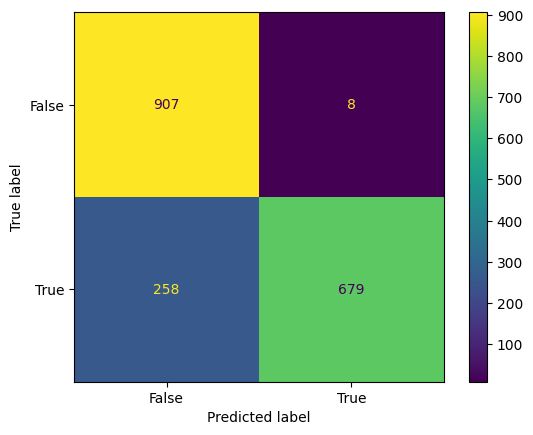

In [108]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

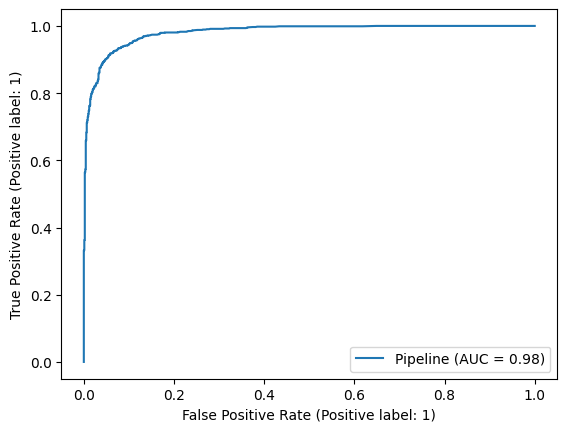

In [ ]:
roc_svc = RocCurveDisplay.from_estimator(svc_link_predictor, X_test, y_test)

### 1.8 - Models comparison

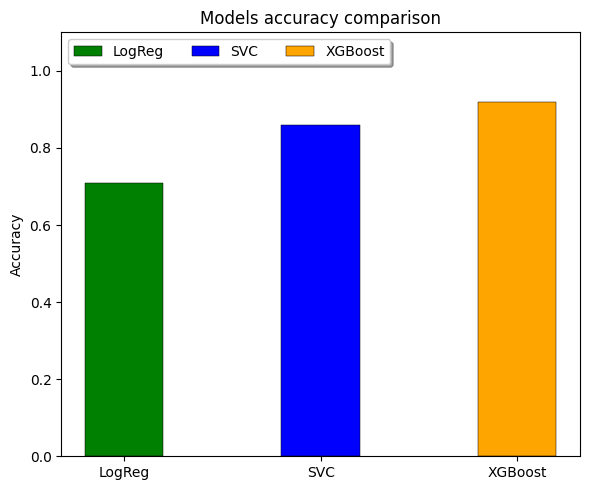

In [145]:
fig, ax = plt.subplots(figsize=(6,5))

models = ['LogReg', 'SVC', 'XGBoost']
acc = [0.71, 0.86, 0.92]

bar_labels = models
bar_colors = ['green', 'blue', 'orange']

ax.bar(models, acc, label=bar_labels, color=bar_colors, width=0.4,
       edgecolor='black', lw=0.35)

ax.set_ylim(0, 1.1)
ax.set_ylabel('Accuracy')
ax.set_title('Models accuracy comparison')
ax.legend(loc='upper left', ncol=3, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# 2 - Recommendation System with Node2Vec

### 2.1 - Crate the graph to perform the recommendation system

In [48]:
# sub-sample keeping 2012 only
sub_beer_df = beer_df[beer_df['review_time'].dt.year >= 2012].copy()
sub_beer_df.shape

(9343, 13)

In [49]:
# keep only profiles that reviewed more than one beer
users_reviews_count = sub_beer_df['user'].value_counts()
kept_profiles_only = users_reviews_count[users_reviews_count>1].index

sub_beer_df = sub_beer_df[sub_beer_df['user'].isin(kept_profiles_only)].copy()
sub_beer_df.shape

(8646, 13)

In [50]:
# Create an empty graph
user_beer_graph = nx.Graph()

# Add nodes for users and beers
user_beer_graph.add_nodes_from(sub_beer_df['user'], bipartite='user')
user_beer_graph.add_nodes_from(sub_beer_df['beer_name'], bipartite='beer')

# Add edges representing user-beer interactions
for _, row in sub_beer_df.iterrows():
    user_beer_graph.add_edge(row['user'], row['beer_name'], review=row['review_overall'], abv=row['beer_abv'])  

nx.bipartite.is_bipartite(user_beer_graph)

True

### 2.2 - A brief introduction & intuitions

Link to the paper: https://arxiv.org/pdf/1607.00653.pdf

$\textcolor{red}{\textbf{Breadth-first Sampling (BFS)}}$ The neighborhood $N_{s}$ is restricted to nodes which are immediate neighbors of the source.
For example, in Figure 1 for a neighborhood of size k = 3, BFS samples nodes $s_{1}, s_{2}, s_{3}$.

$\textcolor{blue}{\textbf{Depth-first Sampling (DFS)}}$ The neighborhood consists of nodes sequentially sampled at increasing distances from the source node. In Figure 1, DFS samples $s_{4}, s_{5}, s_{6}$.

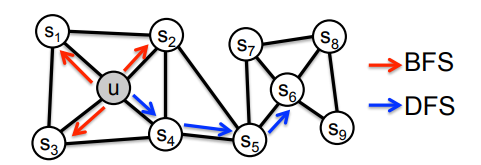

Under the homophily hypothesis, nodes that are highly interconnected and belong to similar network clusters or communities should be embedded closely together (e.g.,
nodes $s_{1}$ and $u$ in Figure 1 belong to the same network community). 

In contrast, under the structural equivalence hypothesis nodes that have similar structural roles in networks should be embedded closely together (e.g., nodes $u$ and $s_{6}$ in Figure 1 act as hubs of their corresponding communities).

**In-Out Parameter q** allows the search to differentiate between “inward” and “outward” nodes:
- If $\textcolor{red}{q>1}$, the random walk is biased towards nodes close to node $t$. Such walks obtain a local view of the underlying graph with respect to the start node in the walk and $\textcolor{red}{\text{approximate BFS behavior}}$.
- If $\textcolor{blue}{q<1}$, the walk is more inclined to visit nodes which are further away from the node $t$. Such behavior $\textcolor{blue}{\text{is reflective of DFS}}$ which encourages outward exploration. 

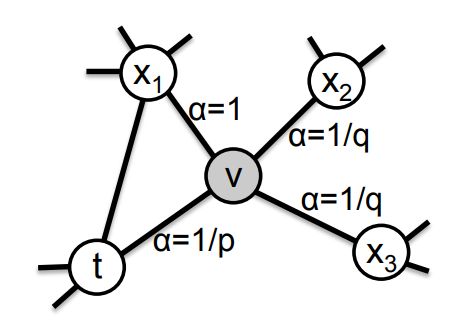

**Parameter p** controls the likelihood of immediately revisiting a node in the walk. 
 - Setting it to a $\textcolor{blue}{\text{high value}}$ (> max(q, 1)) ensures that we are less likely to sample an already visited node in the following two steps. This strategy $\textcolor{blue}{\text{encourages moderate exploration}}$. 
- On the other hand, $\textcolor{red}{\text{if p is low}}$ (< min(q, 1)), it would lead the walk to backtrack a step and this would $\textcolor{red}{\text{keep the walk “local”}}$ close to the starting node u.

### 2.3 - Depth First Search

In [91]:
def recommend_beers(user, num_recommendations=3):

    similar_beers = []

    for reviewer in model.wv.most_similar(str(user))[:num_recommendations]:
        similar_beers.append(reviewer)

    print(similar_beers)

In [100]:
# generate random walks
DFS = Node2Vec(user_beer_graph, dimensions=48, 
                    walk_length=50, num_walks=50,
                    p=2, q=0.7, workers=1)              # q<1 & p>max(0.7, 1) --> DFS

model = DFS.fit(window=10, min_count=2, batch_words=3)

Generating walks (CPU: 1): 100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


In [101]:
recommended_beers = recommend_beers('gtermi')
print([recommended_beers])

[("Mickey's", 0.988726794719696), ('Robert The Bruce Scottish Ale', 0.8936495184898376), ('Old #38 Stout', 0.8882735371589661)]
[None]


### 2.4 - Breadth First Search

In [ ]:
# generate random walks
BFS = Node2Vec(user_beer_graph, dimensions=48, 
                    walk_length=50, num_walks=50,
                    p=2, q=0.7, workers=1)              # q>1 & p<min(1.3, 1) --> BFS

model = BFS.fit(window=10, min_count=2, batch_words=3)

Computing transition probabilities: 100%|██████████| 5254/5254 [00:00<00:00, 7029.23it/s]


[('lmdengis', 0.8514260649681091)]


In [129]:
recommended_beers = recommend_m('Knapp85')
print(recommended_beers)

TEST: [('Maple Oat Ale', 0.9966978430747986), ('Kingfisher Premium Lager', 0.9966949224472046), ('Newbold IPA', 0.9951694011688232), ('Hitachino Nest Red Rice Ale', 0.9950690865516663), ("He'Brew Rejewvenator (Year Of The Date) 2009", 0.9944223761558533), ("D' Inn'Staade", 0.9943467378616333), ('Ménage À Frog', 0.9941058158874512), ('Sinebrychoff Porter', 0.993694543838501), ('Grozet Gooseberry & Wheat Ale', 0.9931186437606812)]
[]
None
